In [46]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim


## File Naming Convention

Each `.pt` file should follow this format:

```
<label>_<replicate>.pt
```

**Examples:**
- `150_1.pt` → Label: 150 (undetectable), Replicate: 1
- `500_2.pt` → Label: 500 (low), Replicate: 2
- `7000_3.pt` → Label: 7000 (medium), Replicate: 3
- `20000_5.pt` → Label: 20000 (high), Replicate: 5



## Class Definitions for Semi-Quantitative approach 

Infers clinical decision-making based on viral load counts (assuming 1:1 sample prep
)
1. `undetectable` → Label values `< 200`
2. `low` → Label values `200 ≤ label ≤ 1000`
3. `medium` → Label values `1000 < label ≤ 10000`
4. `high` → Label values `> 10000`

# Dataset Folder Structure

Dataset is organized into the following structure to ensure proper training, validation, and testing:

```
Datasets/
│-- SemiQuant/
│   │-- Training/             # Training dataset (60% of total data)
│   │   ├── undetectable/      # Class 0 (e.g., files with labels < 200)
│   │   │   ├── 20_1.pt
│   │   │   ├── 40_3.pt
│   │   │   └── ...
│   │   ├── low/               # Class 1 (200 ≤ label ≤ 1000)
|   |   |   ├── 300_2.pt
│   │   │   ├── 600_4.pt
│   │   │   └── ...
│   │   ├── medium/            # Class 2 (1000 < label ≤ 10000)
│   │   │   ├── 2000_1.pt
│   │   │   ├── 7000_2.pt
│   │   │   └── ...
│   │   ├── high/              # Class 3 (label > 10000)
│   │   │   ├── 10000_2.pt
│   │   │   ├── 90000_2.pt
│   │   │   └── ...
│
│   │-- Validation/            # Validation dataset (20% of total data)
│   │   ├── undetectable/
│   │   │   ├── 20_2.pt
│   │   │   ├── 40_4.pt
│   │   │   └── ...
│   │   ├── low/
│   │   ├── medium/
│   │   ├── high/
│
│   │-- Testing/               # Testing dataset (20% of total data)
│   │   ├── undetectable/
│   │   │   ├── 30_1.pt
│   │   │   ├── 50_2.pt
│   │   │   └── ...
│   │   ├── low/
│   │   ├── medium/
│   │   ├── high/
│
│-- torch_tensors/              # Original .pt files before splitting
│   │   ├── 100_1.pt
│   │   ├── 200_3.pt
│   │   ├── 5000_2.pt
│   │   ├── 15000_4.pt
│   │   └── ...
```

## Folder Descriptions

- **`Training/`** – Used to train the model (60% of total data).
- **`Validation/`** – Used to validate the model during training (20% of total data).
- **`Testing/`** – Used to evaluate the model after training (20% of total data).
- **`torch_tensors/`** – Stores the original `.pt` files before they were split.



In [37]:
# reduced image HxW from 500x500 to 224x224 to inprove speed for intial test 
class PTDataset(Dataset):
    def __init__(self, root_dir, target_size=(224, 224), transform=None):
        """
        Args:
            root_dir (str): Path to the dataset directory (e.g., Training folder).
            target_size (tuple): Desired output size (height, width).
            transform (callable, optional): Optional transformations.
        """
        self.root_dir = root_dir
        self.target_size = target_size
        self.transform = transform
        self.classes = ['undetectable', 'low', 'medium', 'high']
        
        # Collect all file paths and labels
        self.file_list = []
        for label in self.classes:
            class_path = os.path.join(root_dir, label)
            for file in os.listdir(class_path):
                if file.endswith('.pt'):
                    self.file_list.append((os.path.join(class_path, file), self.classes.index(label)))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]

        # Load the tensor from file
        tensor_data = torch.load(file_path, weights_only=True)  # Shape [C, T, H, W]

        # Ensure the tensor has enough frames
        max_frames = tensor_data.shape[1]  
        # Frame selection with safe index handling
        selected_frame_indices = [69, 89, 109, 129, 149, 179] #Still need to plot average sigmoidal curve for better channels
        selected_frame_indices = [i for i in selected_frame_indices if i < max_frames]

        if len(selected_frame_indices) < 6:
            raise ValueError(f"Not enough frames in {file_path}, available: {max_frames}, required: 180")

        # Extract the required frames safely
        avg_first_20 = torch.mean(tensor_data[:, :20, :, :], dim=1, keepdim=True)  # Shape [C, 1, H, W]
        selected_frames = tensor_data[:, selected_frame_indices, :, :]  # Shape [C, 6, H, W]

        # Concatenate to form a 7-channel tensor
        final_tensor = torch.cat((avg_first_20, selected_frames), dim=1)  # Shape [C, 7, H, W]

        # Convert from [C, 7, H, W] -> [7, H, W] by removing the channel dimension if necessary
        if final_tensor.shape[0] == 1:  # If the first dimension is singleton, remove it
            final_tensor = final_tensor.squeeze(0)  # Shape becomes [7, H, W]
        else:
            final_tensor = final_tensor.squeeze()  # General squeeze to avoid extra dims

        # Resize each channel to the target size (e.g., 224x224)
        resized_tensor = torch.stack([
            TF.resize(final_tensor[i].unsqueeze(0), self.target_size).squeeze(0) for i in range(final_tensor.shape[0])
        ]) 

        # Apply transformations if provided
        if self.transform:
            resized_tensor = self.transform(resized_tensor)

        return resized_tensor, label


In [38]:
# Define paths data
train_dataset_path = 'M:/Datasets/SemiQuant/Training/'
val_dataset_path = 'M:/Datasets/SemiQuant/Validation/'
test_dataset_path = 'M:/Datasets/SemiQuant/Testing/'

# Load datasets
train_dataset = PTDataset(root_dir=train_dataset_path, target_size=(500, 500))
val_dataset = PTDataset(root_dir=val_dataset_path, target_size=(500, 500))
test_dataset = PTDataset(root_dir=test_dataset_path, target_size=(500, 500))

#DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

for batch in train_loader:
    inputs, labels = batch
    print(f"Batch input shape: {inputs.shape}")  # Expected [batch_size, 7, 224, 224]
    print(f"Batch labels: {labels}")
    break


Batch input shape: torch.Size([32, 7, 500, 500])
Batch labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


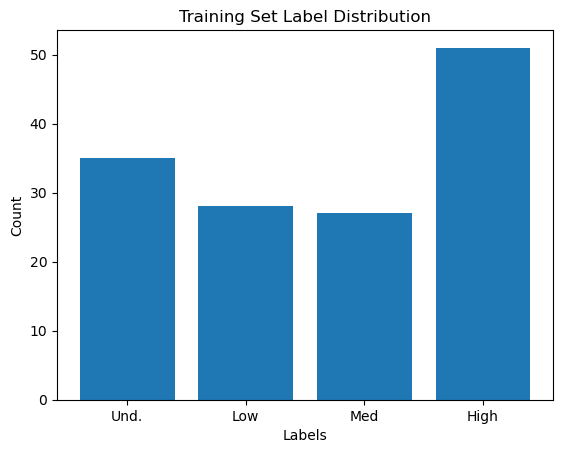

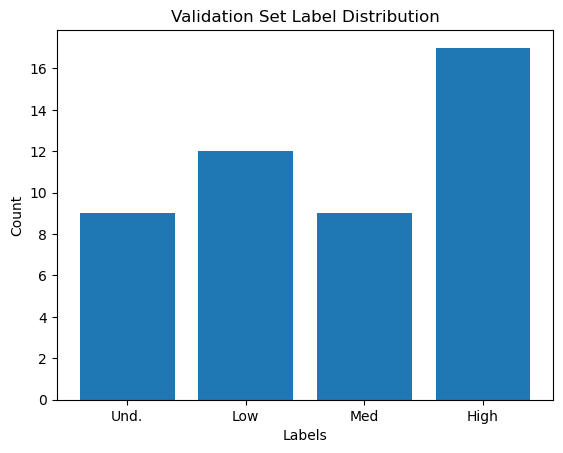

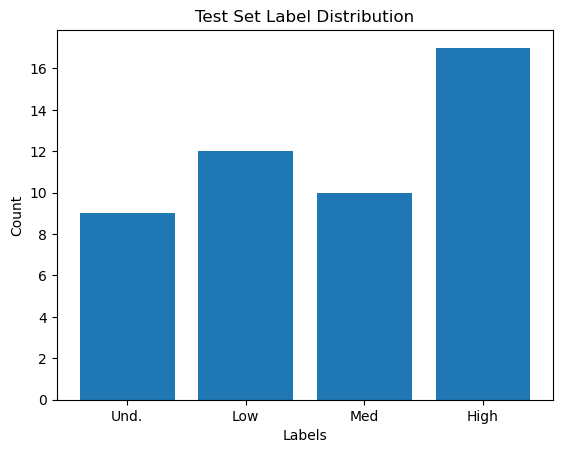

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

def get_label_distribution(dataset):
    labels = [label for _, label in dataset]  # Assuming (data, label) format
    label_counts = Counter(labels)
    return label_counts

label_mapping = {0: "Und.", 1: "Low", 2: "Med", 3: "High"}

train_label_counts = get_label_distribution(train_dataset)
val_label_counts = get_label_distribution(val_dataset)
test_label_counts = get_label_distribution(test_dataset)

def plot_label_distribution(label_counts, title):
    labels, counts = zip(*sorted(label_counts.items()))  
    custom_labels = [label_mapping[label] for label in labels] 
    
    plt.bar(custom_labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

# Plot distributions
plot_label_distribution(train_label_counts, "Training Set Label Distribution")
plot_label_distribution(val_label_counts, "Validation Set Label Distribution")
plot_label_distribution(test_label_counts, "Test Set Label Distribution")


In [39]:
def get_resnet_model(num_classes=4, input_channels=7):
    model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    model.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

device = torch.device("cpu") #no gpu available at this time

model = get_resnet_model(num_classes=4, input_channels=7).to(device)
criterion = nn.BCEWithLogitsLoss() #used CossEntroyLoss but only pred High
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
def one_hot_encode(labels, num_classes):
    return F.one_hot(torch.tensor(labels), num_classes=num_classes).float()

def train_model(model, train_loader, val_loader, criterion, optimizer, num_classes=4, num_epochs=10):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure the number of classes is passed correctly
            labels_one_hot = one_hot_encode(labels, num_classes).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass

            loss = criterion(outputs, labels_one_hot)  # BCEWithLogitsLoss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Convert sigmoid outputs to probabilities
            predicted = torch.sigmoid(outputs)

            # Convert to class predictions by choosing the highest probability class
            predicted_classes = predicted.argmax(dim=1)

            # Compare with true labels to count correct predictions
            correct += (predicted_classes == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    print("Training complete.")


def evaluate_model(model, loader, criterion, num_classes=4):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to one-hot encoding
            labels_one_hot = one_hot_encode(labels, num_classes).to(device)

            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels_one_hot)
            running_loss += loss.item()

            # Convert logits to probabilities and get the predicted class index
            predicted_classes = torch.sigmoid(outputs).argmax(dim=1)

            correct += (predicted_classes == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

In [52]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


C:\Users\CDM\AppData\Local\Temp\ipykernel_12728\4132149669.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return F.one_hot(torch.tensor(labels), num_classes=num_classes).float()


Epoch 1/10, Loss: 0.7136, Accuracy: 21.28%
Epoch 2/10, Loss: 0.5925, Accuracy: 26.95%
Epoch 3/10, Loss: 0.5793, Accuracy: 28.37%
Epoch 4/10, Loss: 0.5398, Accuracy: 55.32%
Epoch 5/10, Loss: 0.5086, Accuracy: 36.17%
Epoch 6/10, Loss: 0.4959, Accuracy: 36.17%
Epoch 7/10, Loss: 0.4819, Accuracy: 36.17%
Epoch 8/10, Loss: 0.4629, Accuracy: 36.17%
Epoch 9/10, Loss: 0.4537, Accuracy: 36.17%
Epoch 10/10, Loss: 0.4465, Accuracy: 36.17%
Training complete.


In [56]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

torch.save(model.state_dict(), 'resnet_model.pth')
print("Model saved as resnet_model.pth")

model.load_state_dict(torch.load('resnet_model.pth'))
model.eval()
print("Model loaded for inference.")

C:\Users\CDM\AppData\Local\Temp\ipykernel_12728\2216032419.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return F.one_hot(torch.tensor(labels), num_classes=num_classes).float()


Test Loss: 0.5060, Test Accuracy: 35.42%
Final Test Loss: 0.5060, Test Accuracy: 35.42%
Model saved as resnet_model.pth
Model loaded for inference.


C:\Users\CDM\AppData\Local\Temp\ipykernel_12728\2137013694.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet_model.pth'))


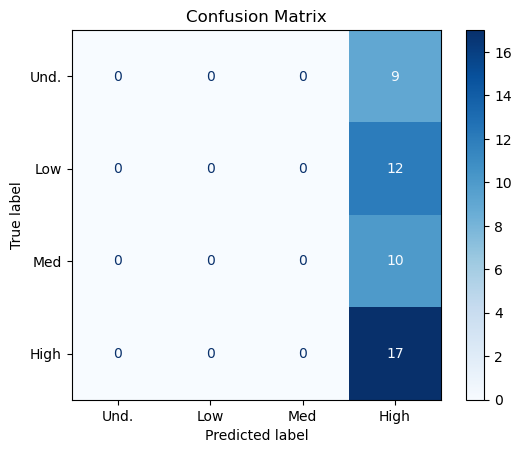

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the model is in evaluation mode
model.eval()

# Move model to appropriate device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Collect all true labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy()) 
        all_labels.extend(labels.cpu().numpy())  

conf_matrix = confusion_matrix(all_labels, all_preds)

class_names = ['Und.', 'Low', 'Med', 'High']  


disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


0


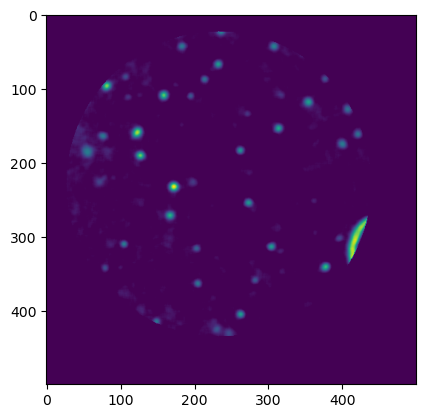

In [33]:
print(train_dataset[7][1])
plt.imshow(train_dataset[7][0][-1,:,:])